In [1]:
# Import packages 
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import cv2

from tqdm.auto import tqdm
from ipywidgets import FloatProgress
from scipy import ndimage
from PIL import Image
from importlib import reload

# append path
sys.path.append('../')

# custom
from utils.BuildUNet import UNet
from utils.GetLowestGPU import GetLowestGPU
from utils.TileGenerator import TileGenerator
from utils.IOU import iou
from utils.AreaCalc import area_calc
import utils.SegmentImage as SegmentImage
import utils.MeasureLeaves as MeasureLeaves

device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 02710MiB / 40537MiB
  1  | 02332MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 00003MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 00003MiB / 40537MiB
---------------------------
 Device set to cuda:2
---------------------------


# Import Best Model Weights

In [2]:
# Load model
# instantiate model
model_kwargs = {
    'layer_sizes': [16, 32, 64, 128, 256],
    'in_channels': 3,
    'out_channels': 4,
    'conv_per_block': 3,
    'dropout_rate': 0.1,
    'hidden_activation': torch.nn.LeakyReLU(),
    'output_activation': None,
}

unet = UNet(**model_kwargs)
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3)
loss_function = torch.nn.CrossEntropyLoss()


In [3]:
# find iteration with lowest loss
log_path = '../logs/'
log = pd.read_csv(log_path + 'log.csv')
best_loss = log.iloc[log["val_loss"].idxmin()]["iter_num"].astype(int)

In [4]:
# load model weights
checkpoint = torch.load(f"../checkpoints/checkpoint_{best_loss}.pt", map_location=device)

#extract weights from checkpoint
weights = checkpoint["model"]
# trained model has been loaded
unet.load_state_dict(weights)
unet.eval()#inference mode (no dropout, batch norm uses running mean, etc.)
unet.to(device)

UNet(
  (hidden_activation): LeakyReLU(negative_slope=0.01)
  (enc_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout2d(p=0.1, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): Batch

# Load Images

In [5]:
# load in images
# options
image_path = "../pennycress_pods/test/test_images/"
mask_path = "../pennycress_pods/test/test_masks/"
save_path = "../pennycress_pods/test/test_predictions/"

# load image data
image_names = glob.glob(mask_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

# Create Predicted Segmentation Masks for Images

Processing 9_5.tt8t x fc5-1.B.WBP-2022.W_rep2.png


  0%|          | 0/9265 [00:00<?, ?it/s]

Jaccard Distance (IoU) for wing: 0.9653

Jaccard Distance (IoU) for envelope: 0.9263

Jaccard Distance (IoU) for seeds: 0.5346

Processing 1.tt8t x fc6-1.B.WBP-2022.W.png


  0%|          | 0/9265 [00:00<?, ?it/s]

Jaccard Distance (IoU) for wing: 0.9622

Jaccard Distance (IoU) for envelope: 0.9310

Jaccard Distance (IoU) for seeds: 0.6792

Processing 10.tt8t x fc5-2.B.WBP-2022.W.png


  0%|          | 0/9265 [00:00<?, ?it/s]

Jaccard Distance (IoU) for wing: 0.9711

Jaccard Distance (IoU) for envelope: 0.9383

Jaccard Distance (IoU) for seeds: 0.6928

Average Jaccard Distance (IoU) for wing: 0.9662

Average Jaccard Distance (IoU) for envelope: 0.9319

Average Jaccard Distance (IoU) for seeds: 0.6355



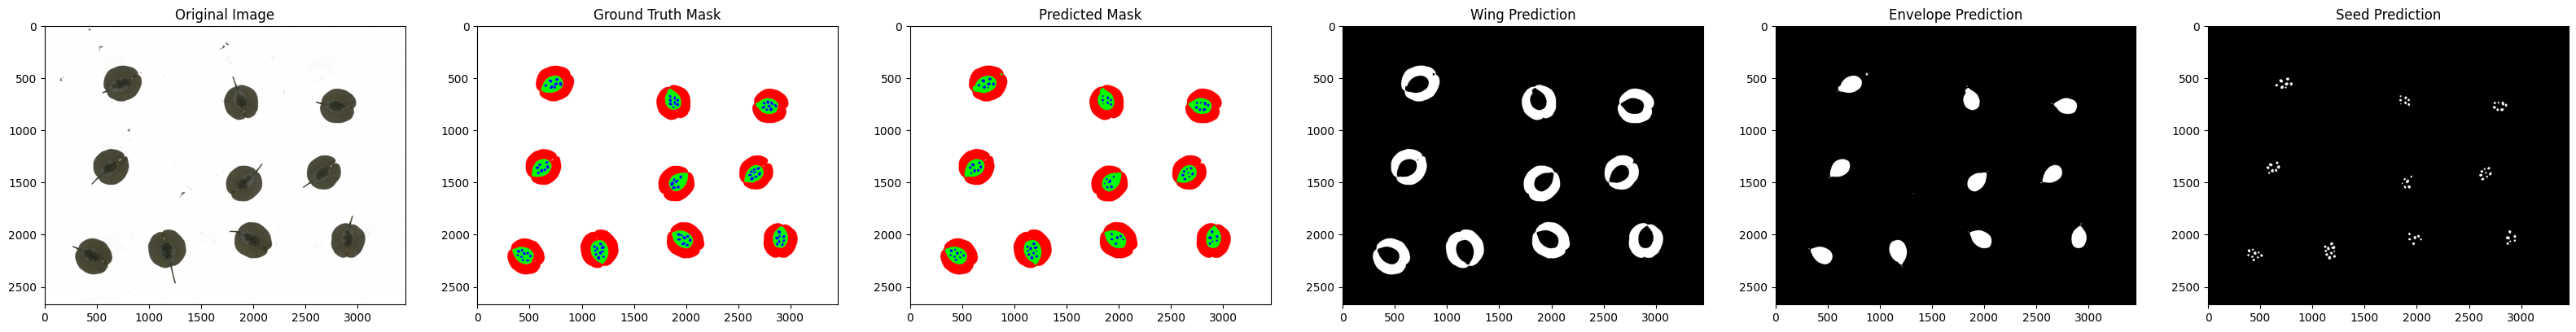

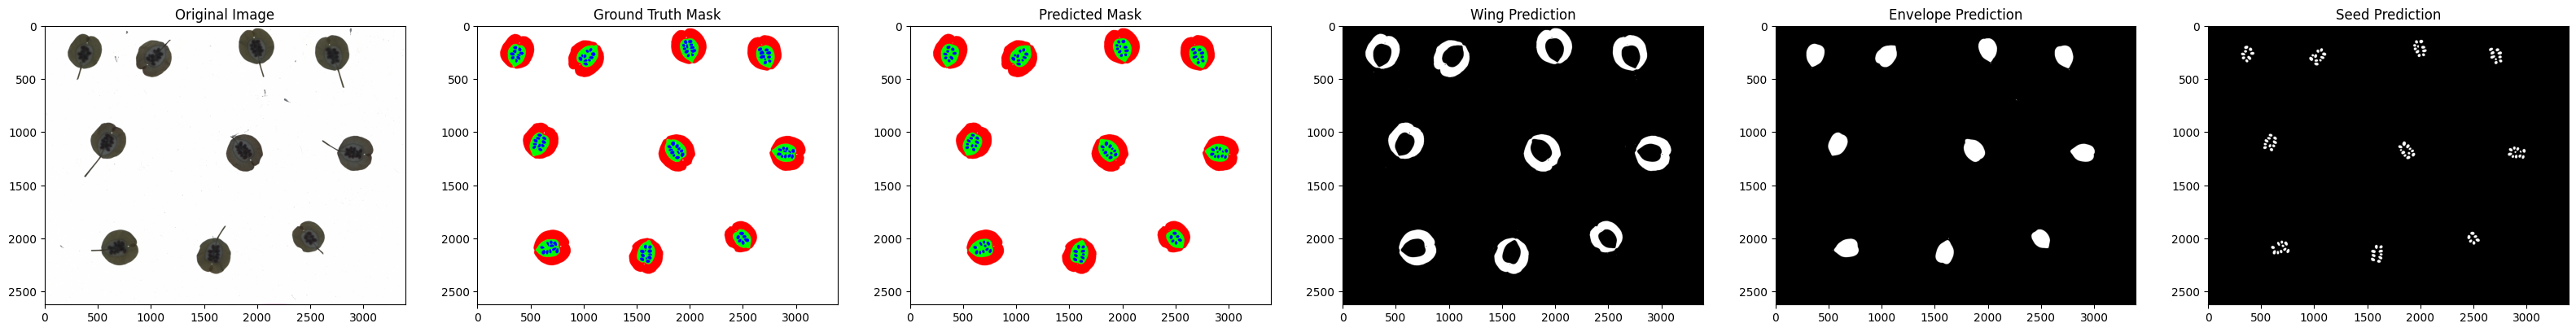

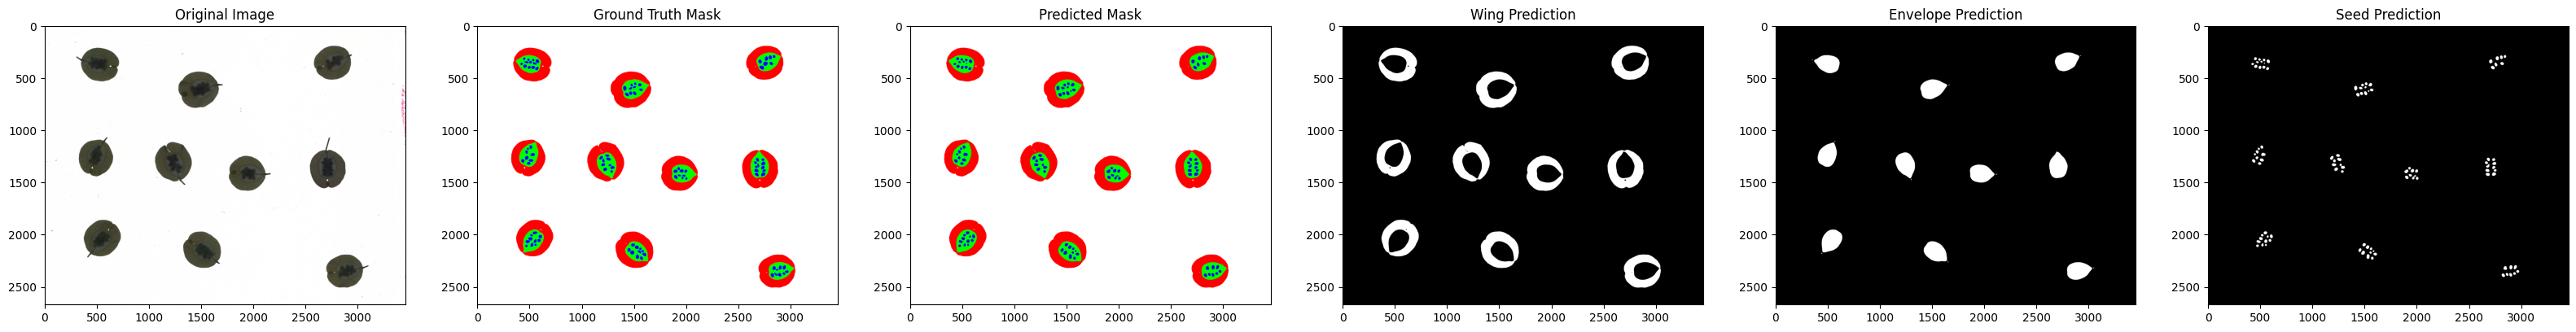

In [6]:
reload(SegmentImage)
SegmentImage.segment_image(model = unet,
                           image_names = image_names,
                           image_path = image_path,
                           mask_path = mask_path,
                           save_path = save_path,
                           plot = True,
                           verbose = 2,
                           device = device)

# Seed Counting

In [7]:
## OPTIONS
pred_path = "../pennycress_pods/test/test_predictions/"
pod_save_path = "../pennycress_pods/test/test_predictions_by_pod/"
measurement_save_path = "../pennycress_pods/test/test_measurements/"

pred_image_names = glob.glob(pred_path + "*.png")
pred_image_names = [os.path.basename(x) for x in pred_image_names]

wing area: 1.34 cm | env area: 0.07 cm | seed area: 0.23 cm
seed count: 1


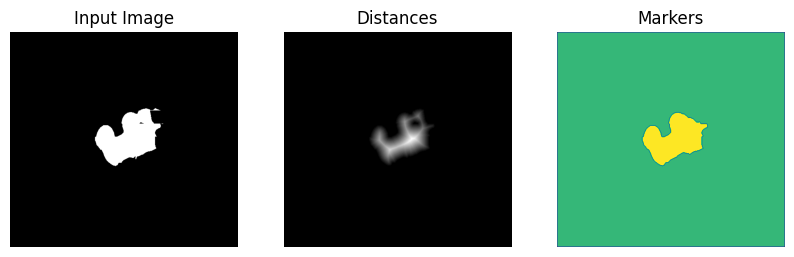

wing area: 1.27 cm | env area: 0.08 cm | seed area: 0.32 cm
seed count: 1


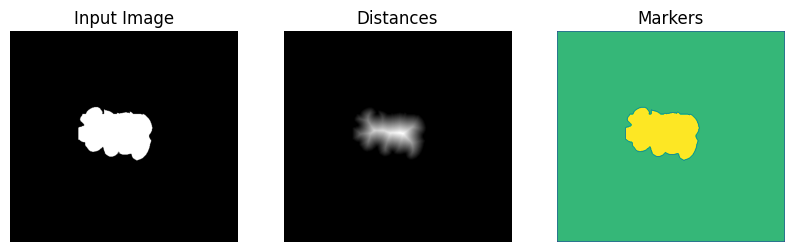

wing area: 1.44 cm | env area: 0.12 cm | seed area: 0.32 cm
seed count: 1


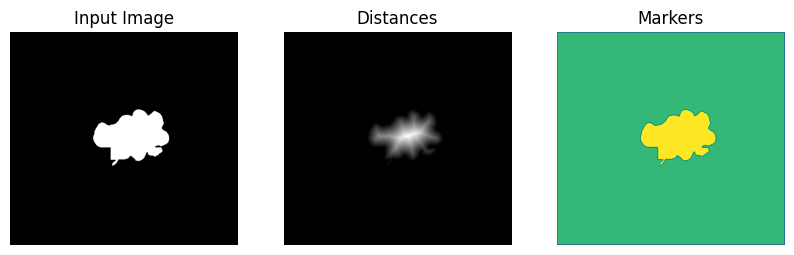

wing area: 1.24 cm | env area: 0.08 cm | seed area: 0.30 cm
seed count: 1


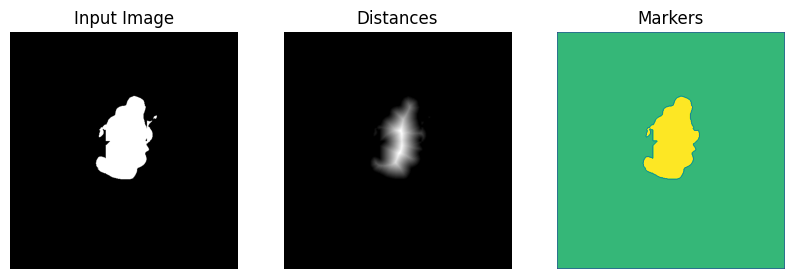

wing area: 1.42 cm | env area: 0.10 cm | seed area: 0.29 cm
seed count: 2


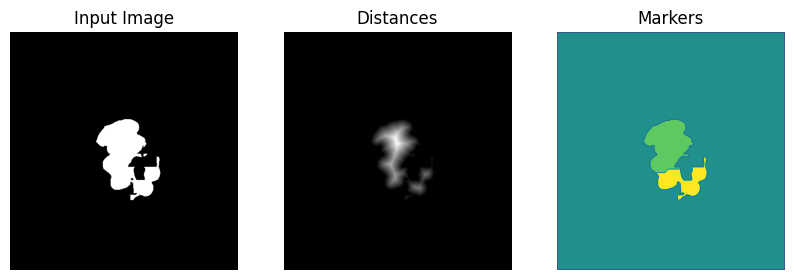

wing area: 1.31 cm | env area: 0.17 cm | seed area: 0.32 cm
seed count: 1


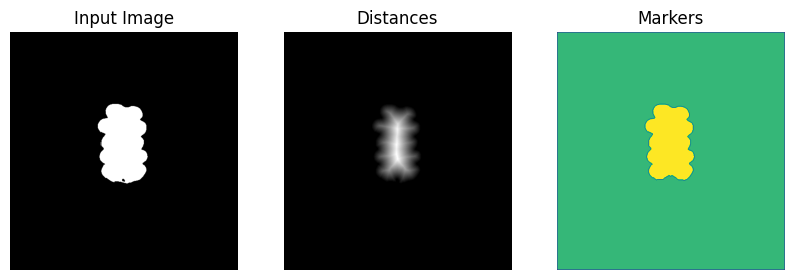

wing area: 1.37 cm | env area: 0.08 cm | seed area: 0.21 cm
seed count: 1


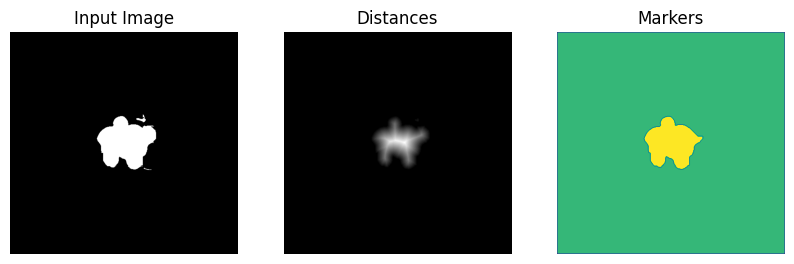

wing area: 1.31 cm | env area: 0.09 cm | seed area: 0.31 cm
seed count: 1


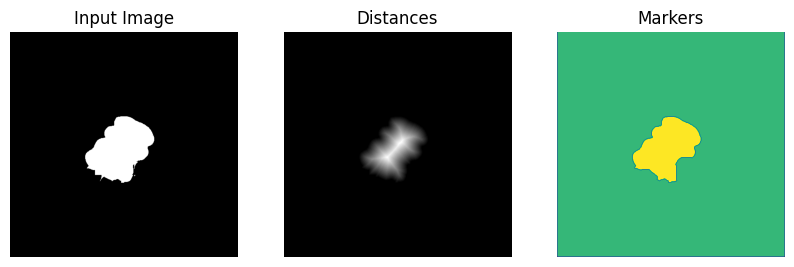

wing area: 1.39 cm | env area: 0.07 cm | seed area: 0.31 cm
seed count: 1


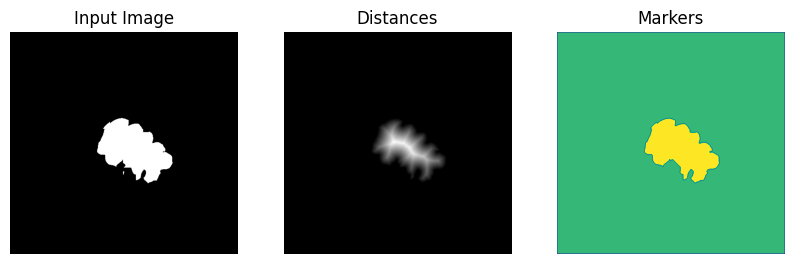

wing area: 1.22 cm | env area: 0.10 cm | seed area: 0.29 cm
seed count: 1


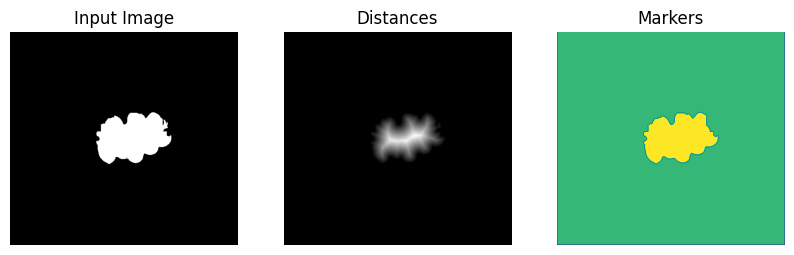

wing area: 1.72 cm | env area: 0.03 cm | seed area: 0.01 cm
seed count: 3


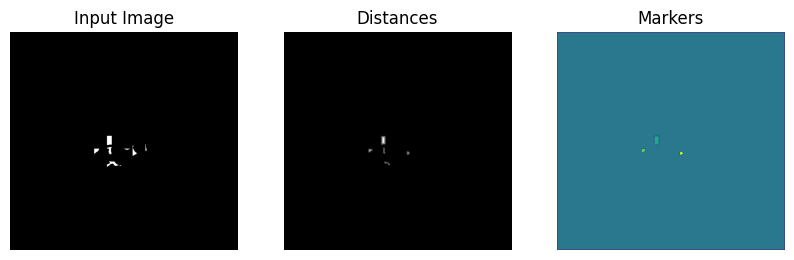

wing area: 1.55 cm | env area: 0.00 cm | seed area: 0.01 cm
seed count: 4


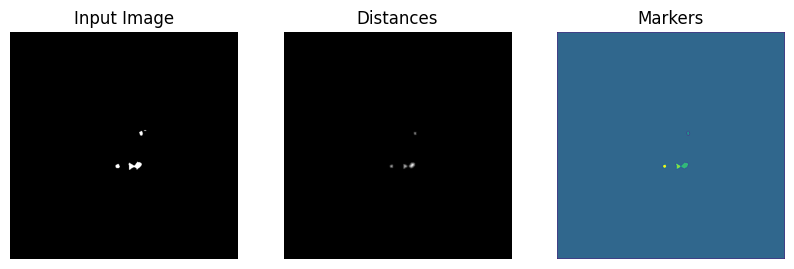

wing area: 1.60 cm | env area: 0.01 cm | seed area: 0.01 cm
seed count: 2


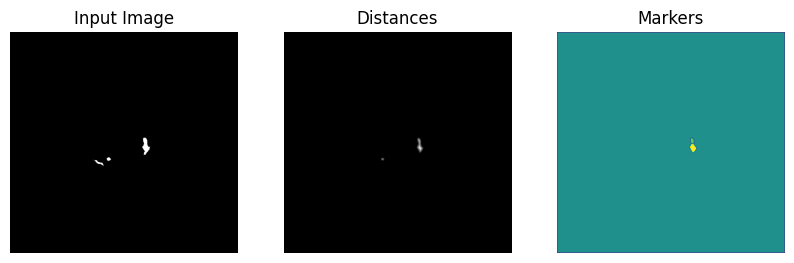

wing area: 1.44 cm | env area: 0.05 cm | seed area: 0.16 cm
seed count: 1


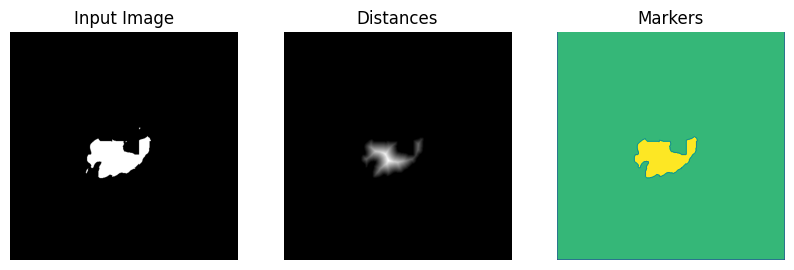

wing area: 1.38 cm | env area: 0.03 cm | seed area: 0.09 cm
seed count: 1


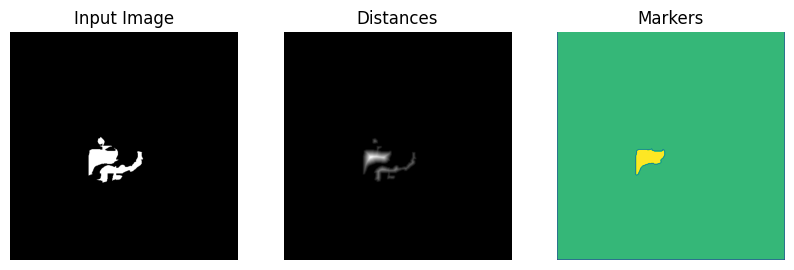

wing area: 1.62 cm | env area: 0.01 cm | seed area: 0.03 cm
seed count: 3


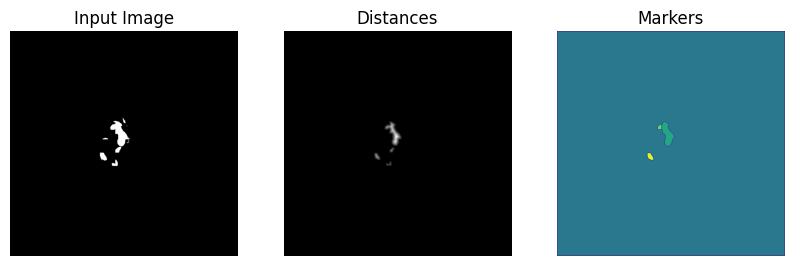

wing area: 1.66 cm | env area: 0.00 cm | seed area: 0.07 cm
seed count: 2


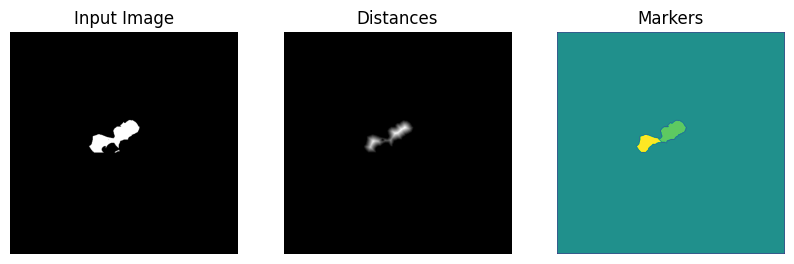

wing area: 1.48 cm | env area: 0.02 cm | seed area: 0.07 cm
seed count: 2


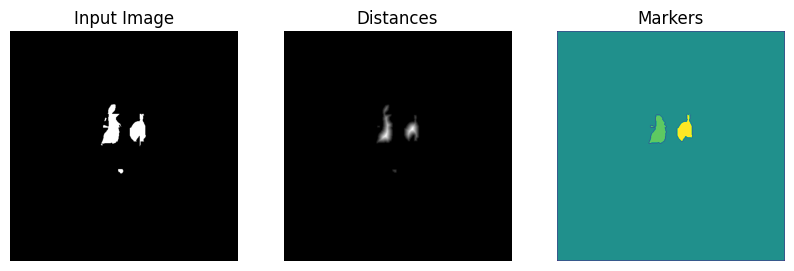

wing area: 1.57 cm | env area: 0.06 cm | seed area: 0.23 cm
seed count: 2


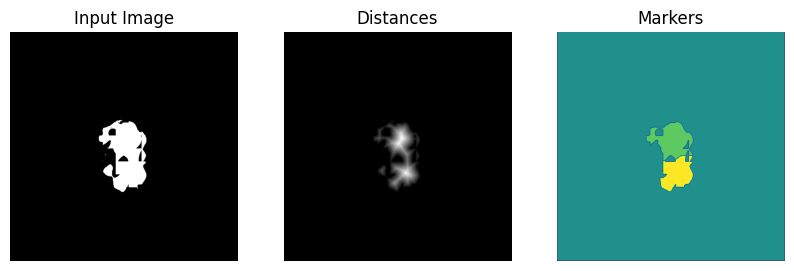

wing area: 1.61 cm | env area: 0.02 cm | seed area: 0.06 cm
seed count: 4


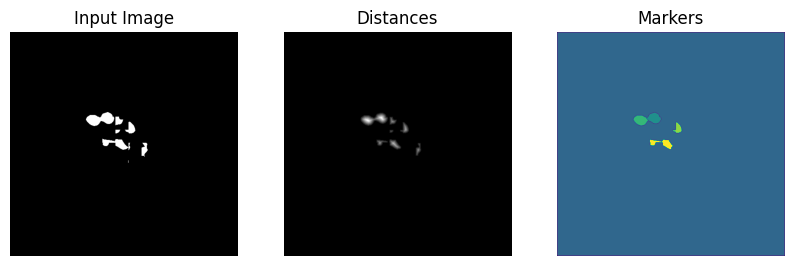

wing area: 1.13 cm | env area: 0.18 cm | seed area: 0.29 cm
seed count: 1


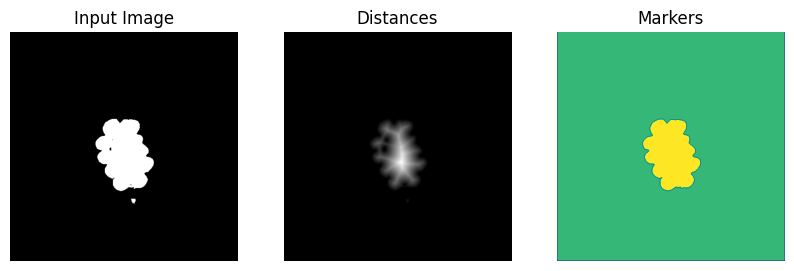

wing area: 1.01 cm | env area: 0.19 cm | seed area: 0.25 cm
seed count: 1


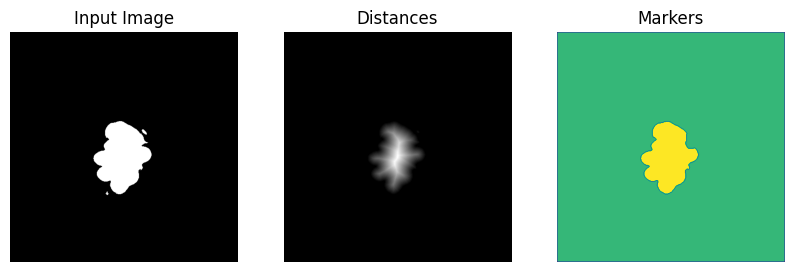

wing area: 1.08 cm | env area: 0.17 cm | seed area: 0.27 cm
seed count: 1


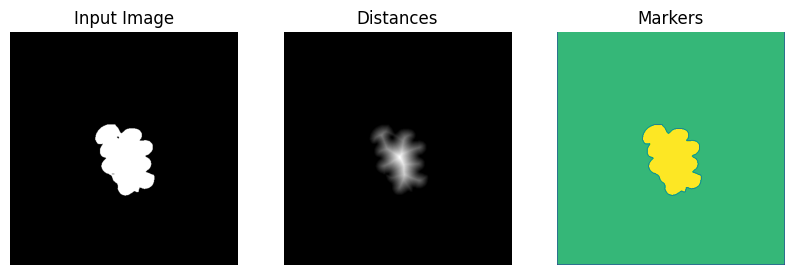

wing area: 1.11 cm | env area: 0.22 cm | seed area: 0.27 cm
seed count: 2


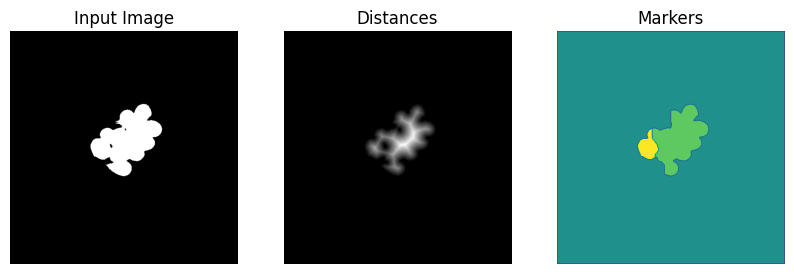

wing area: 1.08 cm | env area: 0.18 cm | seed area: 0.29 cm
seed count: 2


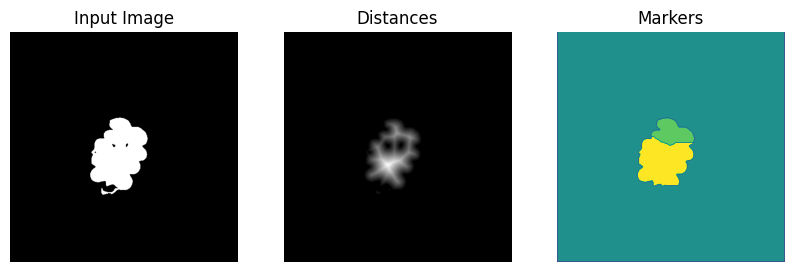

wing area: 1.14 cm | env area: 0.20 cm | seed area: 0.31 cm
seed count: 1


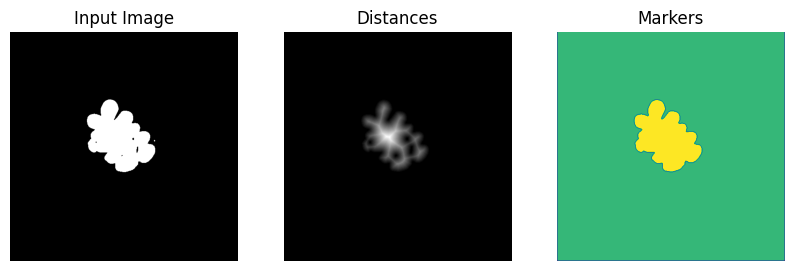

wing area: 1.10 cm | env area: 0.20 cm | seed area: 0.27 cm
seed count: 2


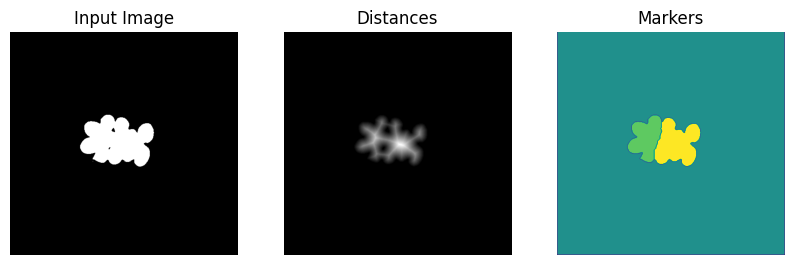

wing area: 0.86 cm | env area: 0.16 cm | seed area: 0.20 cm
seed count: 3


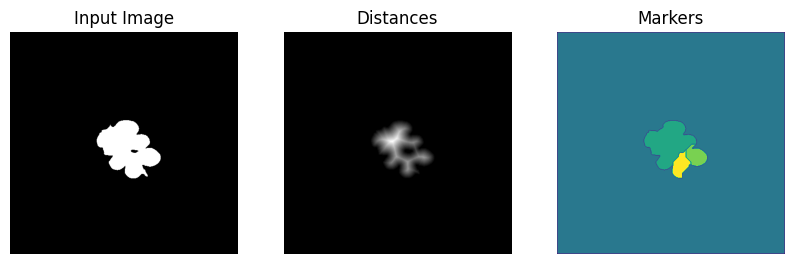

wing area: 1.20 cm | env area: 0.12 cm | seed area: 0.32 cm
seed count: 1


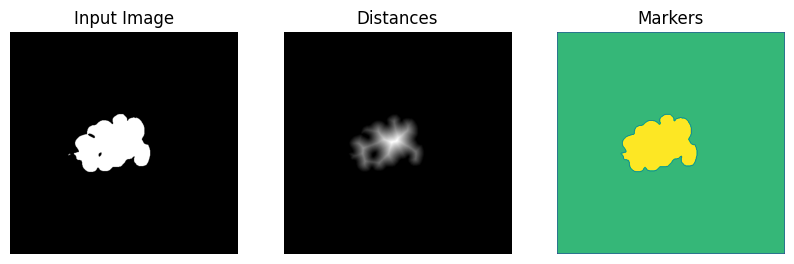

wing area: 1.07 cm | env area: 0.15 cm | seed area: 0.30 cm
seed count: 7


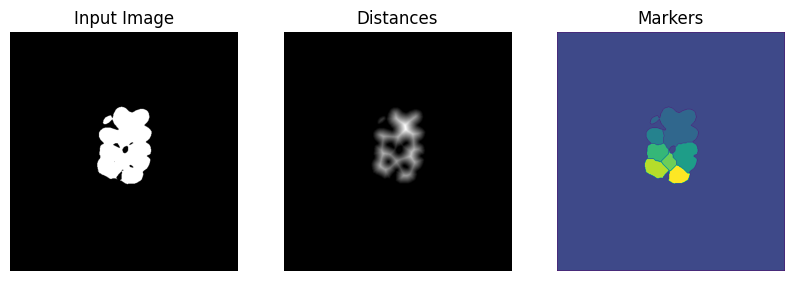

Avg. Seed Count: 1.87 seeds Avg. Wing Area: 1.32 cm Avg. Envelope Area: 0.10 cm Avg. Seed Area: 0.21 cm


In [8]:
reload(MeasureLeaves)

MeasureLeaves.measure_leaves(pred_path = pred_path,
                             pod_save_path = pod_save_path,
                             measurement_save_path = measurement_save_path,
                             image_names = pred_image_names)